In [221]:
import string
import numpy as np
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn import metrics
import patsy

from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [222]:
final_df = pd.read_csv('./final_df.csv')
final_df.columns = ['unnamed', 'unnamed1', 'sonnet_index', 'syllables', 's1', 's2', 's3',
       's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12',
       'word_list', 'sonnet_num', 'author', 'polarity', 'subjectivity', 'sonnet']

# unnecessary columns

final_df = final_df.drop('unnamed', axis=1)
final_df = final_df.drop('unnamed1', axis=1)


final_df.head()

,sonnet_index,syllables,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,word_list,sonnet_num,author,polarity,subjectivity,sonnet
0,0,12,unstress,unstress,unstress,stress,unstress,unstress,stress,unstress,unstress,unstress,stress,unstress,"['It', 'is', 'a', 'truth', 'universally', 'ack...",0,Austen,0.0000,0.0,0
1,1,10,unstress,stress,unstress,stress,unstress,stress,stress,stress,unstress,stress,missing,missing,"['However', 'little', 'known', 'the', 'feeling...",1,Austen,-0.1875,0.5,0
2,2,10,stress,stress,stress,stress,unstress,stress,stress,stress,unstress,stress,missing,missing,"['My', 'dear', 'Mr', 'Bennet', 'said', 'his', ...",2,Austen,0.0000,0.0,0
3,3,9,stress,stress,stress,unstress,stress,missing,stress,stress,stress,missing,missing,missing,"['But', 'it', 'is', 'returned', 'she;', 'for',...",3,Austen,-0.0500,0.4,0
4,4,12,stress,stress,stress,stress,stress,stress,stress,stress,stress,unstress,stress,stress,"['Do', 'you', 'not', 'want', 'to', 'know', 'wh...",4,Austen,0.0000,0.0,0


In [223]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12302 entries, 0 to 12301
Data columns (total 20 columns):
sonnet_index    12302 non-null int64
syllables       12302 non-null int64
s1              12302 non-null object
s2              12302 non-null object
s3              12302 non-null object
s4              12302 non-null object
s5              12302 non-null object
s6              12302 non-null object
s7              12302 non-null object
s8              12302 non-null object
s9              12302 non-null object
s10             12302 non-null object
s11             12302 non-null object
s12             12302 non-null object
word_list       12302 non-null object
sonnet_num      12302 non-null int64
author          12218 non-null object
polarity        12302 non-null float64
subjectivity    12302 non-null float64
sonnet          12302 non-null int64
dtypes: float64(2), int64(4), object(14)
memory usage: 1.9+ MB


In [224]:
final_df.shape

(12302, 20)

# Baseline

In [225]:
print np.mean(final_df.sonnet)

0.416111201431


# Logistic Regression

In [226]:
logreg = LogisticRegression()

formula = 'sonnet ~ syllables + C(s1) + C(s2) + C(s3) + C(s4) + C(s5) + C(s6) + C(s7) + C(s8) + C(s9) + C(s10) + C(s11) + C(s12) + polarity + subjectivity -1'
Y, X = patsy.dmatrices(formula, data=final_df)

In [227]:
interaction_formula = ''' sonnet ~ syllables + (C(s1) + C(s2) + C(s3) + C(s4) + C(s5) + C(s6) + C(s7) + C(s8) + 
C(s9) + C(s10) + C(s11) + C(s12))**2 + polarity + subjectivity -1'''
Yint, Xint = patsy.dmatrices(interaction_formula, data=final_df, return_type='dataframe')
Xint = (Xint - Xint.mean()) / Xint.std()
Xint.dropna(axis=1, inplace=True)

In [228]:
Yint.shape, Xint.shape

((12302, 1), (12302, 292))

In [229]:
Y.shape, X.shape

((12302, 1), (12302, 28))

In [230]:
np.mean(Y)

array(0.41611120143066166)

In [234]:
scores = cross_val_score(logreg, X, np.ravel(Y), cv=5)
print scores
print np.mean(scores)

[ 0.83990248  0.85127997  0.87200325  0.85528455  0.8804392 ]
0.859781890529


In [231]:
scores = cross_val_score(logreg, Xint.values, np.ravel(Yint), cv=5)
print scores
print np.mean(scores)

[ 0.85453068  0.87525396  0.88947582  0.87642276  0.89263928]
0.877664502343


In [232]:
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV

lr_params = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.logspace(-5,1,25)
}

gs = GridSearchCV(LogisticRegression(), lr_params, cv=5, verbose=1)

gs.fit(Xint.values, Yint.values.ravel())

print gs.best_score_
print gs.best_params_
best_dtc = gs.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    6.3s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:  2.4min
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 11.1min finished


0.879369208259
{'penalty': 'l2', 'C': 0.01, 'solver': 'liblinear'}


In [235]:
logreg.fit(X,np.ravel(Y))
pp = logreg.predict_proba(X)
y_pred_50pct = logreg.predict(X)

model_features = ['syllables', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 'polarity', 'subjectivity']

# zip(model_features, logreg.coef_)

len(model_features), len(logreg.coef_[0])
len(X.design_info.column_names), len(logreg.coef_[0])

(28, 28)

# Example


    # you have:
    already_fit_model
    
    def conversion_function(new_line):
        # outputs 2d Xtest matrix with the new_line data converted to
        # the same format patsy outputs for the X matrix above
        # ONLY DO FOR NON-INTERACTION MODEL!
        return Xtest
        
    # now you have Xtest
    # predicted if sonnet is 1 or zero
    predicted_if_sonnet = already_fit_model.predict(Xtest)
    
    # if you want confidence in the prediction:
    predprob_if_sonnet = already_fit_model.predict_proba(Xtest)
    
    # predicted probability is a 2 column matrix where the first
    # column is probability that it is not a sonnet, 2nd
    # column is probability that it is a sonnet


In [ ]:
example_df = pd.read_csv('./assets/example_text_df.csv')
example_df.columns = ['unnamed', 'sonnet_index', 'syllables', 's1', 's2', 's3',
       's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12',
       'word_list', 'sonnet_num', 'author', 'polarity', 'subjectivity', 'sonnet']

# unnecessary columns

example_df = example_df.drop('unnamed', axis=1)
example.head()

# Coefficients

In [236]:
coef_df = pd.DataFrame(zip(X.design_info.column_names, logreg.coef_[0]))
coef_df.columns = ['variables', 'coefficients']
coef_df = coef_df.sort('coefficients')
coef_df.head(3)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,variables,coefficients
8,C(s4)[T.unstress],-3.535785
24,C(s12)[T.unstress],-2.515562
12,C(s6)[T.unstress],-2.412931


In [237]:
turn_df = coef_df.T
turn_df.columns = [x for x in coef_df['variables']]
graph_col = list(turn_df.columns)
turn_df = turn_df.ix[1:]
turn_df

,C(s4)[T.unstress],C(s12)[T.unstress],C(s6)[T.unstress],C(s2)[T.unstress],C(s12)[T.stress],C(s11)[T.stress],C(s8)[T.unstress],C(s11)[T.unstress],C(s9)[T.stress],C(s4)[T.stress],...,C(s10)[T.unstress],C(s7)[T.unstress],C(s3)[T.unstress],C(s5)[T.unstress],C(s10)[T.stress],polarity,syllables,subjectivity,C(s1)[missing],C(s1)[unstress]
coefficients,-3.53578,-2.51556,-2.41293,-2.32876,-2.24717,-2.2359,-1.83732,-1.80406,-1.66601,-1.49724,...,-0.633813,-0.0726857,0.135355,0.239483,0.266084,0.358142,0.765961,0.898341,0.905255,1.10405


In [239]:
# print graph_col
new_graph_col = list(set(graph_col)-set(['Intercept','syllables','polarity','subjectivity']))
# print '-'*20
# print new_graph_col

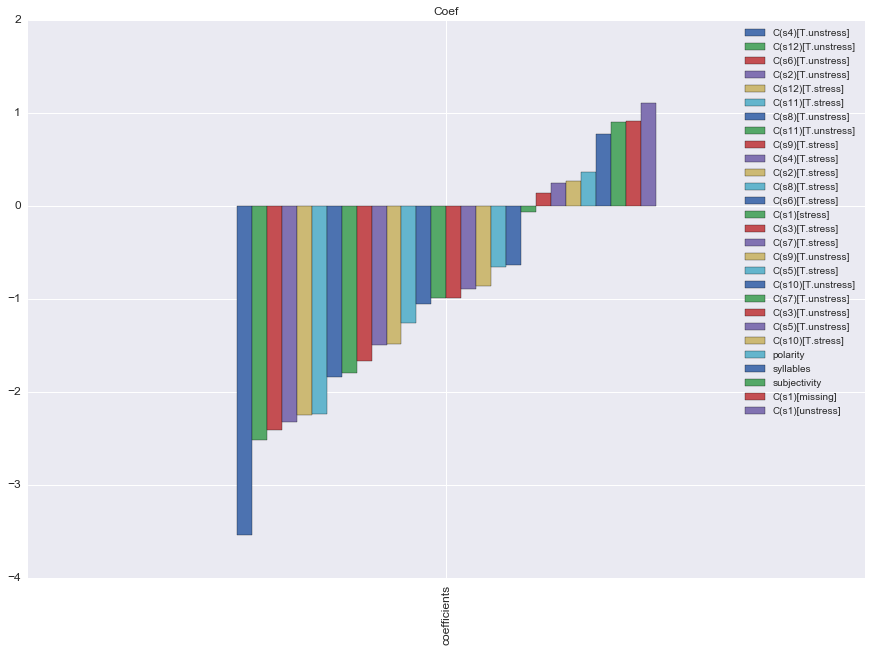

In [240]:
ax = turn_df[graph_col].plot(kind='bar', 
                    title ="Coef",
                    figsize=(15,10),
                    legend=True, 
                    fontsize=12)
plt.show()

# Confusion Matrix

In [241]:
Ytrue = pd.Series(np.ravel(Y))
Ypred50 = pd.Series(y_pred_50pct)
pd.crosstab(Ytrue, Ypred50, rownames = ['True'], colnames = ['Predicted'], margins = True)

Predicted,0.0,1.0,All
True,,,
0.0,6421,762,7183
1.0,937,4182,5119
All,7358,4944,12302


In [242]:
print 6421./7183
print 4182./5119

0.893916191007
0.816956436804


In [243]:
print classification_report(Ytrue, Ypred50)

             precision    recall  f1-score   support

        0.0       0.87      0.89      0.88      7183
        1.0       0.85      0.82      0.83      5119

avg / total       0.86      0.86      0.86     12302



precision: of all those guessed as sonnets how many were sonnets

recall: of all the real sonnets how many were predicted as sonnets

F1: weighted average between precision and recall

# ROC curve

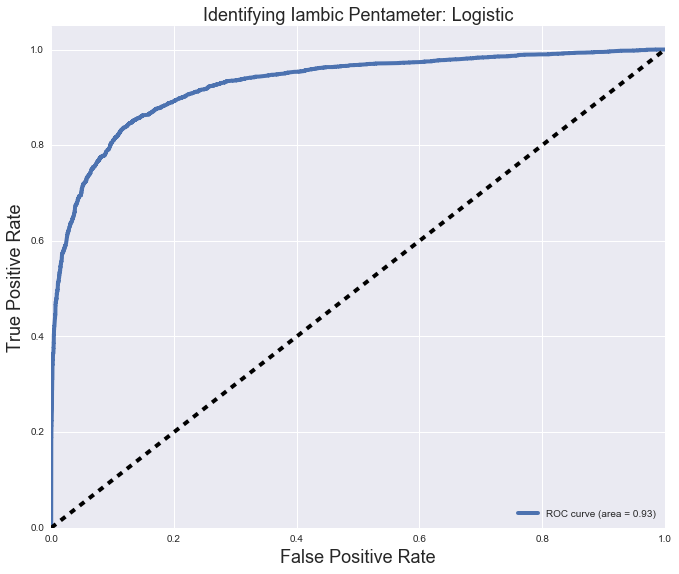

In [244]:
Y_score = logreg.decision_function(X)

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(Ytrue, Y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Identifying Iambic Pentameter: Logistic', fontsize=18)
plt.legend(loc="lower right")
plt.show()

# Exploration

In [245]:
# first not sonnet, second sonnet

pp = logreg.predict_proba(X)
ypred = logreg.predict(X)

p_not_iambic = pp[:,0]
p_is_iambic = pp[:,1]
mistakes_df = final_df
mistakes_df['algorithm'] = ypred
mistakes_df['p_not_iambic'] = p_not_iambic
mistakes_df['p_is_iambic'] = p_is_iambic
mistakes_df.head()

,sonnet_index,syllables,s1,s2,s3,s4,s5,s6,s7,s8,...,s12,word_list,sonnet_num,author,polarity,subjectivity,sonnet,algorithm,p_not_iambic,p_is_iambic
0,0,12,unstress,unstress,unstress,stress,unstress,unstress,stress,unstress,...,unstress,"['It', 'is', 'a', 'truth', 'universally', 'ack...",0,Austen,0.0000,0.0,0,0.0,0.971753,0.028247
1,1,10,unstress,stress,unstress,stress,unstress,stress,stress,stress,...,missing,"['However', 'little', 'known', 'the', 'feeling...",1,Austen,-0.1875,0.5,0,1.0,0.023501,0.976499
2,2,10,stress,stress,stress,stress,unstress,stress,stress,stress,...,missing,"['My', 'dear', 'Mr', 'Bennet', 'said', 'his', ...",2,Austen,0.0000,0.0,0,1.0,0.469327,0.530673
3,3,9,stress,stress,stress,unstress,stress,missing,stress,stress,...,missing,"['But', 'it', 'is', 'returned', 'she;', 'for',...",3,Austen,-0.0500,0.4,0,0.0,0.962482,0.037518
4,4,12,stress,stress,stress,stress,stress,stress,stress,stress,...,stress,"['Do', 'you', 'not', 'want', 'to', 'know', 'wh...",4,Austen,0.0000,0.0,0,0.0,0.995630,0.004370


In [217]:
# mistakes_df['pp_choice'] = (mistakes_df.p_not_iambic < mistakes_df.p_is_iambic).astype(float)

In [218]:
# np.sum(mistakes_df.algorithm != mistakes_df.pp_choice)

In [246]:
mistakes = final_df['sonnet'] != final_df['algorithm']
my_mistakes = final_df[mistakes]
my_mistakes.sort('p_is_iambic', ascending=False)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,sonnet_index,syllables,s1,s2,s3,s4,s5,s6,s7,s8,...,s12,word_list,sonnet_num,author,polarity,subjectivity,sonnet,algorithm,p_not_iambic,p_is_iambic
3439,128,10,stress,stress,missing,missing,unstress,stress,stress,stress,...,missing,"['At', 'three', 'oclock', 'precisely', 'I', 'w...",128,Doyle,0.400000,0.800000,0,1.0,0.016786,0.983214
1,1,10,unstress,stress,unstress,stress,unstress,stress,stress,stress,...,missing,"['However', 'little', 'known', 'the', 'feeling...",1,Austen,-0.187500,0.500000,0,1.0,0.023501,0.976499
4973,1662,11,unstress,stress,unstress,stress,unstress,unstress,unstress,stress,...,missing,"['The', 'rooms', 'were', 'carefully', 'examine...",1662,Doyle,-0.100000,1.000000,0,1.0,0.027949,0.972051
5679,2368,9,unstress,unstress,unstress,stress,unstress,stress,unstress,stress,...,missing,"['It', 'was', 'a', 'homely', 'little', 'room']",2368,Doyle,-0.187500,0.500000,0,1.0,0.028035,0.971965
5145,1834,10,unstress,stress,unstress,stress,unstress,stress,stress,stress,...,missing,"['Inspector', 'Bradstreet', 'would', 'I', 'am'...",1834,Doyle,0.500000,0.888889,0,1.0,0.028721,0.971279
4002,691,9,unstress,stress,unstress,stress,unstress,stress,unstress,unstress,...,missing,"['Of', 'course', 'in', 'your', 'position', 'of']",691,Doyle,0.000000,0.000000,0,1.0,0.031347,0.968653
4822,1511,10,unstress,stress,unstress,stress,unstress,unstress,unstress,stress,...,missing,"['The', 'night', 'however', 'was', 'extremely']",1511,Doyle,-0.125000,1.000000,0,1.0,0.032048,0.967952
5105,1794,10,unstress,stress,unstress,stress,unstress,stress,stress,stress,...,missing,"['Inspector', 'Bradstreet', 'sir', 'Ah', 'Brad...",1794,Doyle,0.000000,0.000000,0,1.0,0.034062,0.965938
3539,228,10,unstress,stress,unstress,stress,unstress,stress,stress,stress,...,missing,"['Besides', 'remember', 'that', 'she', 'had', ...",228,Doyle,0.000000,0.000000,0,1.0,0.034062,0.965938
5211,1900,10,unstress,unstress,unstress,stress,unstress,stress,unstress,unstress,...,missing,"['It', 'was', 'a', 'very', 'ordinary', 'black']",1900,Doyle,-0.245833,0.541667,0,1.0,0.040816,0.959184


In [247]:
my_mistakes.sort('p_not_iambic', ascending=False)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,sonnet_index,syllables,s1,s2,s3,s4,s5,s6,s7,s8,...,s12,word_list,sonnet_num,author,polarity,subjectivity,sonnet,algorithm,p_not_iambic,p_is_iambic
11926,1412,10,stress,unstress,stress,unstress,stress,unstress,stress,unstress,...,missing,"['Myself', 'unworthy', 'of', 'the', 'happier',...",101,Christina Rossetti,0.000000,0.000000,1,0.0,0.998702,0.001298
10930,385,11,stress,stress,stress,unstress,stress,unstress,stress,stress,...,missing,"['But', 'my', 'ever', 'waking', 'part', 'shall...",28,John Donne John Don,0.000000,0.000000,1,0.0,0.998401,0.001599
9696,285,10,stress,unstress,stress,unstress,stress,unstress,stress,unstress,...,missing,"['Sandals', 'more', 'interwoven', 'and', 'comp...",21,Keat,0.300000,0.450000,1,0.0,0.997837,0.002163
10301,923,10,stress,unstress,stress,unstress,stress,unstress,stress,unstress,...,missing,"['Sandals', 'more', 'interwoven', 'and', 'comp...",66,Keat,0.300000,0.450000,1,0.0,0.997837,0.002163
9578,164,10,stress,unstress,stress,unstress,stress,unstress,stress,unstress,...,missing,"['Almost', 'the', 'highest', 'bliss', 'of', 'h...",12,Keat,0.300000,0.500000,1,0.0,0.997738,0.002262
10119,721,10,stress,unstress,stress,unstress,stress,unstress,stress,unstress,...,missing,"['Almost', 'the', 'highest', 'bliss', 'of', 'h...",52,Keat,0.300000,0.500000,1,0.0,0.997738,0.002262
8823,1997,12,stress,unstress,stress,stress,stress,stress,stress,stress,...,unstress,"['Even', 'so', 'being', 'full', 'of', 'your', ...",143,Shakespeare,0.350000,0.550000,1,0.0,0.997315,0.002685
10743,196,12,stress,stress,unstress,unstress,stress,stress,stress,stress,...,stress,"['Say', 'over', 'again', 'and', 'yet', 'once',...",15,Elizabeth Barrett Browning poetry,0.000000,0.000000,1,0.0,0.997296,0.002704
10638,91,11,stress,stress,unstress,unstress,stress,unstress,stress,unstress,...,missing,"['Some', 'whispering', 'ghost', 'forgotten', '...",7,Rupert Brooke Ruper,0.000000,0.000000,1,0.0,0.997226,0.002774
10795,249,11,stress,stress,unstress,unstress,stress,unstress,stress,unstress,...,missing,"['Too', 'vehement', 'light', 'dilated', 'my', ...",18,Elizabeth Barrett Browning poetry,0.650000,0.850000,1,0.0,0.996946,0.003054


# Naive Bayes classifier for Bernoulli models. 

In [248]:
bern = BernoulliNB()
bern.fit(X, np.ravel(Y))
pp = bern.predict_proba(X)
y_pred_50pct = bern.predict(X)

Ytrue = pd.Series(np.ravel(Y))
Ypred50 = pd.Series(y_pred_50pct)
pd.crosstab(Ytrue, Ypred50, rownames = ['True'], colnames = ['Predicted'], margins = True)

Predicted,0.0,1.0,All
True,,,
0.0,6151,1032,7183
1.0,1117,4002,5119
All,7268,5034,12302


In [249]:
print 6151./7183
print 4002./5119

0.856327439788
0.781793319008


In [250]:
print classification_report(Ytrue, Ypred50)

             precision    recall  f1-score   support

        0.0       0.85      0.86      0.85      7183
        1.0       0.79      0.78      0.79      5119

avg / total       0.82      0.83      0.83     12302

